# Running this Notebook
Run the first cell (that has all the imports), then the cell with RobotGridSimuation, then exchange2x2, then the cell directly below "Theoretical Behavior". This cell is a test case, where you can generate your own test cases. There are comments on how starting positions, and ending positions can be written. 

Make sure to restart the kernel and clear the output for each test. This is because the way I structured plotting only plots to figure 1. It doesn't actually clear figure 1, it just overlays the new test with the previous test. 

There are buttons for moving back to initial configuration, stepping through the path, and just moving to the solution. It was intended for the starting position to be green, the path to be blue, and the end position to be red, which it does for most cases, but is buggy sometimes.

Each test has been put in its own individual cells, with all the methods copy-pasted. The cell below Theoretical Behavior is one test, while the cell under "Test Cases" is also another test. The reason why methods were copy pasted was not because it was hardcoded or changed to satisfy each test (it's not, that can be verified), but because I thought it'd be easier rather than having to run cells at the top of the notebook, then at the bottom, then at the top again, etc. Not many tests were done because I ran out of time, but each helper method has been tested thoroughly, except for pathgen. Another method that has problems is validAdjacentNodes, since it doesn't consider cells in which robots reside in as an invalid cell.

# Final B: Multi-robot path planning

For your final, you will be studying multiple robots navigating in a grid, such as those that navigate automated warehouses.  The robots move step by step along integer coordinates, and must respect certain validity constraints. Robots must not collide into one another, and there are certain fixed obstacles that cannot be passed through.  They must also stay within the limits of the grid.

As many robots as you wish may move simultaneously at a single time step, as long as one robot does not enter the grid cell occupied by another at the start of the time step.  You can think of this as a robot "reserving" its current grid cell and its next grid cell.  For the robot to make a valid move, moth these grid cells must be unoccupied by another robot at the start and the end of the step.

In [7]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

#these might be useful
from klampt import *
from IPython.display import clear_output
from IPython.display import clear_output,Markdown
import ipywidgets as widgets
import ipyklampt
import numpy as np
import math
import time
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from matplotlib.patches import Rectangle,Circle

class RobotGridSimulation:
    def __init__(self,Nrobots,width,height):
        self.width = width
        self.height = height
        self.robots = [(0,0) for i in range(Nrobots)]
        self.destination = [(0,0) for i in range(Nrobots)]
        self.obstacles = [[False]*height for i in range(width)]
        self.crashed = False
    def state(self):
        return [r for r in self.robots]
    def setState(self,s):
        self.robots = [r for r in s]
    def moveRobot(self,robot,d,check=True):
        if d=='l':
            self.moveRobotLeft(robot,check)
        elif d=='r':
            self.moveRobotRight(robot,check)
        elif d=='u':
            self.moveRobotUp(robot,check)
        elif d=='d':
            self.moveRobotDown(robot,check)
        else:
            raise ValueError("Invalid direction "+d+", must be one of uldr")
    def moveRobotLeft(self,robot,check=True):
        x,y = self.robots[robot]
        self.robots[robot] = (x-1,y)
        if check:
            if not self.valid(robot):
                print "Robot",robot,"crashed while moving left"
                self.crashed = True
                return False
        return True
    def moveRobotRight(self,robot,check=True):
        x,y = self.robots[robot]
        self.robots[robot] = (x+1,y)
        if check:
            if not self.valid(robot):
                print "Robot",robot,"crashed while moving right"
                self.crashed = True
                return False
        return True
    def moveRobotUp(self,robot,check=True):
        x,y = self.robots[robot]
        self.robots[robot] = (x,y+1)
        if check:
            if not self.valid(robot):
                print "Robot",robot,"crashed while moving up"
                self.crashed = True
                return False
        return True
    def moveRobotDown(self,robot,check=True):
        x,y = self.robots[robot]
        self.robots[robot] = (x,y-1)
        if check:
            if not self.valid(robot):
                print "Robot",robot,"crashed while moving down"
                self.crashed = True
                return False
        return True
    def valid(self,robots='all'):
        if robots == 'all':
            robots = range(len(self.robots))
            fixedRobots = []
        elif not hasattr(robots,'__iter__'):
            fixedRobots = [i for i in range(len(self.robots)) if i != robots]
            robots = [robots]
        else:
            rset = set(robots)
            fixedRobots = [i for i in range(len(self.robots)) if i not in rset]
        rpos = set()
        for r in fixedRobots:
            rpos.add(self.robots[r])
        for r in robots:
            xy = self.robots[r]
            if xy[0] < 0 or xy[0] >= self.width:
                return False
            if xy[1] < 0 or xy[1] >= self.height:
                return False
            if self.obstacles[xy[0]][xy[1]]:
                return False
            if xy in rpos:
                return False
            rpos.add(xy)
        return True
    def plot(self,ax, color=None):
        for i in range(len(self.obstacles)):
            for j in range(len(self.obstacles[i])):
                if self.obstacles[i][j]:
                    ax.add_patch(Rectangle((i,j),1,1,fill=True,color=(0.5,0.5,0.5),zorder=0))
        for r in self.robots:
            i,j = r
            if color is None:
                ax.add_patch(Circle((i+0.5,j+0.5),0.4,fill=True,lw=1,color='b',zorder=4))                
            if color == 0:
                ax.add_patch(Circle((i+0.5,j+0.5),0.4,fill=True,lw=1,color='g',zorder=4))
            elif color == 1:
                ax.add_patch(Circle((i+0.5,j+0.5),0.4,fill=True,lw=1,color='r',zorder=4))                
            else:
                ax.add_patch(Circle((i+0.5,j+0.5),0.4,fill=True,lw=1,color='b',zorder=4))                
        ax.plot([0,self.width,self.width,0,0],[0,0,self.height,self.height,0],lw=1,color='k')
    def plotPaths(self,path,ax):
        mvs = [[] for r in self.robots]
        for (rob,mv) in path:
            mvs[rob].append(mv)
        paths = [[r] for r in self.robots]
        for i,actions in enumerate(mvs):
            for mv in actions:
                self.moveRobot(i,mv,check=False)
                paths[i].append(self.robots[i])
            if len(paths[i]) > 1:
                ax.plot([v[0]+0.5 for v in paths[i]],[v[1]+0.5 for v in paths[i]],lw=1,color='g')
        #restore state
        self.robots = [path[0] for path in paths]

## Example problems

Here are some simple examples

In [ ]:
sim = RobotGridSimulation(5,20,10)
for i in range(3,15):
    for j in range(3,10):
        sim.obstacles[i][j] = True

for i in range(12,15):
    for j in range(5,8):
        sim.obstacles[i][j] = True

sim.robots[0] = (0,0)
sim.robots[1] = (3,4)
sim.robots[2] = (15,0)
sim.robots[3] = (18,9)
sim.robots[4] = (2,9)


In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.subplot(111)
plt.axis('equal')
sim.plot(ax)
plt.show()

In [ ]:
#do this then run the cell above to update the sim
sim.moveRobotRight(0)
sim.moveRobotRight(0)
sim.moveRobotRight(0)

In [ ]:
sim.moveRobotDown(1)

In [ ]:
hallway = RobotGridSimulation(6,10,6)
for i in range(3,7):
    for j in range(0,2):
        hallway.obstacles[i][j] = True
    for j in range(4,6):
        hallway.obstacles[i][j] = True
hallway.robots[0] = (0,0)
hallway.robots[1] = (1,0)
hallway.robots[2] = (2,0)
hallway.robots[3] = (7,0)
hallway.robots[4] = (8,0)
hallway.robots[5] = (9,0)

In [ ]:
fig = plt.figure()
ax = plt.subplot(111)
plt.axis('equal')
hallway.plot(ax)
plt.show()

## Exchange policies

The problem of coordinating multiple robots in narrow passages can be very hard, such as when the above hallway is shrunk to 1 cell across.  If two robots enter a narrow hallway, there is going to certainly be *deadlock* where one cannot make progress toward its goal without the other reversing its progress.

However, an efficient *exchange policy* can be applied in certain scenarios to avoid deadlocks. Under the following conditions:

* Two robots are in a free 2x2 square
* Each robot has a path in mind such that the next step toward their goals is also contained within the square
* There are no obstacles or other robots in the square
* Their next-step goals are not the same cell

In this case, either the robots can proceed to make progress toward their goals, or one can move out of the way so the other can pass.

In [9]:
def exchange2x2(a0,b0,adest,bdest):
    """Given a and b within a 2x2 cell with no other obstacles, returns
    a sequence of moves that will get a from position a0 to adest and b
    from position b0 to bdest.
    
    The sequence is a list in the form ['au','bl*','ar'] where the first
    character is the object to move, and the second character is the direction
    (u: up, d: down, r: right, l: left)
    If the third character * is given, then this means it can be done at the same time as the 
    previous action
    """
    assert a0 != b0,"Objects have the same start?"
    assert adest != bdest,"Objects have the same destination?"
    xlow = min(a0[0],b0[0],adest[0],bdest[0])
    assert max(a0[0],b0[0],adest[0],bdest[0]) <= xlow+1,"Objects aren't in a 2x2 box?"
    ylow = min(a0[1],b0[1],adest[1],bdest[1])
    assert max(a0[1],b0[1],adest[1],bdest[1]) <= ylow+1,"Objects aren't in a 2x2 box?"
    a0 = (a0[0]-xlow,a0[1]-ylow)
    b0 = (b0[0]-xlow,b0[1]-ylow)
    aorig = a0
    adest = (adest[0]-xlow,adest[1]-ylow)
    bdest = (bdest[0]-xlow,bdest[1]-ylow)
    path = []
    while a0 != adest or b0 != bdest:
        aopts = []
        aacts = []
        bopts = []
        bacts = []
        if adest[0] > a0[0]:
            aopts.append((1,a0[1]))
            aacts.append('r')
        elif adest[0] < a0[0]:
            aopts.append((0,a0[1]))
            aacts.append('l')
        if adest[1] > a0[1]:
            aopts.append((a0[0],1))
            aacts.append('u')
        elif adest[1] < a0[1]:
            aopts.append((a0[0],0))
            aacts.append('d')
        if bdest[0] > b0[0]:
            bopts.append((1,b0[1]))
            bacts.append('r')
        elif bdest[0] < b0[0]:
            bopts.append((0,b0[1]))
            bacts.append('l')
        if bdest[1] > b0[1]:
            bopts.append((b0[0],1))
            bacts.append('u')
        elif bdest[1] < b0[1]:
            bopts.append((b0[0],0))
            bacts.append('d')
        #print "A options",aopts,"B options",bopts
        moved = False
        for i in range(len(aopts)):
            if aopts[i] != b0:
                path.append('a'+aacts[i])
                a0 = aopts[i]
                moved = True
                break
        for i in range(len(bopts)):
            if bopts[i] != a0:
                path.append('b'+bacts[i])
                if moved and bopts[i] != aorig:
                    path[-1] = path[-1] + '*'
                b0 = bopts[i]
                moved = True
                break
        if not moved:
            if a0 == adest and b0 == bdest:
                break
            else:
                #might need to move the other out of the way
                if a0[0] == b0[0]:
                    if b0[0] == 0:
                        b0 = (1,b0[1])
                        path.append('br')
                    else:
                        b0 = (0,b0[1])
                        path.append('bl')
                else:
                    assert a0[1] == b0[1]
                    if b0[1] == 0:
                        b0 = (b0[0],1)
                        path.append('bu')
                    else:
                        b0 = (b0[0],0)
                        path.append('bd')
                #print "Moving B out of the way to",b0
    return path

Examples...
['bl']
['ar', 'bl*', 'au', 'bd']
['br', 'au', 'bd*', 'bl']
['ar', 'br*']


<IPython.core.display.Javascript object>


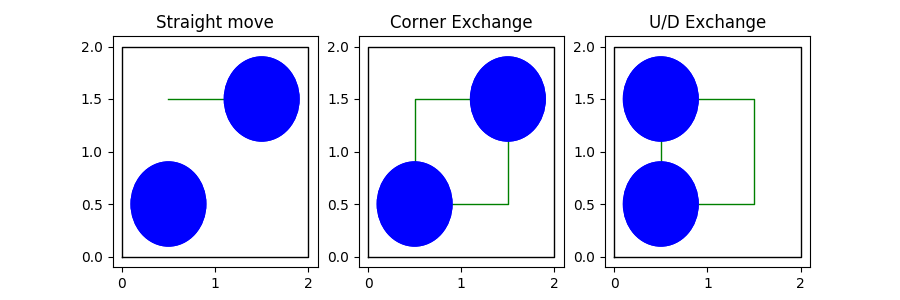

In [6]:
print "Examples..."
soln1 = exchange2x2((3,3),(4,4),(3,3),(3,4))
print soln1
soln2 = exchange2x2((3,3),(4,4),(4,4),(3,3))
print soln2
soln3 = exchange2x2((3,3),(3,4),(3,4),(3,3))
print soln3
soln4 = exchange2x2((3,3),(3,4),(4,3),(4,4))
print soln4
try:
    print exchange2x2((3,3),(5,4),(4,4),(3,3))
    print "HMM.... didn't catch exception?"
except Exception:
    pass

fig = plt.figure(figsize=(9,3))
ax = plt.subplot(131)
sim1 = RobotGridSimulation(2,2,2)
sim1.robots[0] = (0,0)
sim1.robots[1] = (1,1)
sim1.plot(ax)
sim1.plotPaths([((0 if mv[0] =='a' else 1),mv[1]) for mv in soln1],ax)
ax.set_title("Straight move")
ax = plt.subplot(132)
sim2 = RobotGridSimulation(2,2,2)
sim2.robots[0] = (0,0)
sim2.robots[1] = (1,1)
sim2.plot(ax)
sim2.plotPaths([((0 if mv[0] =='a' else 1),mv[1]) for mv in soln2],ax)
ax.set_title("Corner Exchange")
ax = plt.subplot(133)
sim3 = RobotGridSimulation(2,2,2)
sim3.robots[0] = (0,0)
sim3.robots[1] = (0,1)
sim3.plot(ax)
sim3.plotPaths([((0 if mv[0] =='a' else 1),mv[1]) for mv in soln3],ax)
ax.set_title("U/D Exchange")
fig.show()

## Assignment

Your job is to devise a planning approach that uses the exchange method to avoid deadlock.  Assume that each robot has a goal cell, and no two robots have the same goal.  Each robot can plan a path independently of all the other robots.  Can you then use the exchange method whenever two robots cross paths?

Implement such an algorithm.  You may find Dijkstra's algorithm helpful to generate single-robot paths.  It may also be useful to you to define a *next-desired-step* as a robot's next cell along its independently-planned path (this may also be a null movement if it is at the goal) and a *conflict*  as a situation where, for two robots A and B, the cells containing the current position of A and its next-desired-step overlap with the current position of B and its next-desired-step.

In your report, precisely and in technical English language (not code, although pseudocode may be acceptable), describe your strategy for resolving conflicts.  This description should include, but is not limited to:

1. When multiple conflicts are present on a given time step, which robots do you resolve first? 

2. Can you allow non-conflicting robots to move while conflicting robots are moving? 

3. How do you resolve the case when two robots on a single time step are approaching the same cell along their individual paths?


## Theoretical behavior

1. Describe as precisely as possible all of the inputs and outputs of your planner, so that a user of your planner would be able to confidently interpret how to encode and decode the problem.

2. Define as precisely as possible the assumptions under which your planner works, such as the layout of obstacles and the robots' start and goal locations.

3. How does the performance of the planner scale with respect to certain parameters, like the number of robots, grid size, distances between start and goal, or the choice of actions?

4. Describe the theoretical performance qualities of the planner.  Is it complete?  Optimal?  Probabilistic?

HBox()

<IPython.core.display.Javascript object>


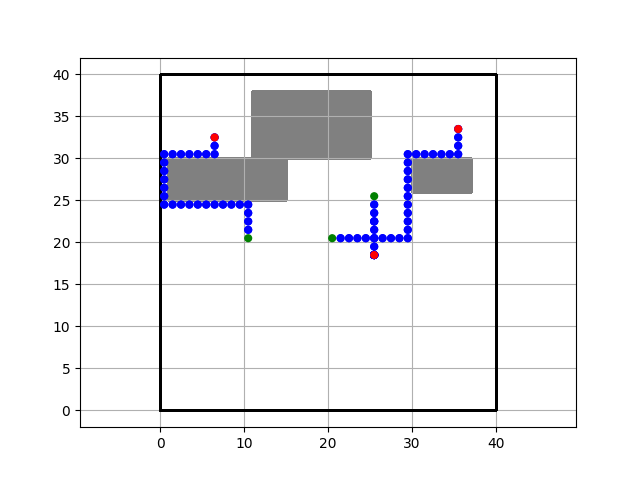

In [13]:
numRobots = 3 ## DECLARE NUMBER OF ROBOTS HERE
grid_dims = [40,40] ## WIDTH,HEIGHT
sim = RobotGridSimulation(numRobots,grid_dims[0],grid_dims[1])
## TO CREATE MORE OBSTACLES JUST ADD TO THE LIST OF THE NEXT FOUR LINES
obs_min_x_dims = [1,11,30] ## I.E. OBSTACLE A GOES FROM X =1 TO X=15, THEN Y=25 TO Y =30
obs_max_x_dims = [15,25,37] ## OBSTACLE B GOES FROM X = 4 TO X =6, THEN Y=6 TO Y=10
obs_min_y_dims = [25,30,26]
obs_max_y_dims = [30,38,30]

## TO CREATE MORE ROBOTS ADD THE X AND Y POSITIONS INTO THE FOLLOWING LISTS, EACH INDEX IS A ROBOT
robotStartX = [10,20,25] ## ROBOT A HAS STARTING COORDS 10,20, ENDING COORDS 6,33
robotStartY = [20,20,25] ## ROBOT B HAS STARTING COORDS 20,20, ENDING COORDS 35,35
robotEndX = [6,35,25]
robotEndY = [33,35,15]

## BUILD ROBOTS
for i in range(numRobots):
    sim.robots[i] = (robotStartX[i],robotStartY[i])
    sim.destination[i] = (robotEndX[i],robotEndY[i])

## BUILD OBSTACLES
for i in range(len(obs_min_x_dims)):
    for j in range(obs_min_x_dims[i],obs_max_x_dims[i]):
        for k in range(obs_min_y_dims[i],obs_max_y_dims[i]):
            sim.obstacles[j][k] = True
            
def bfs(start, end):
    assert start[0] >= 0, "starting x position is less than 0!"
    assert start[0] < grid_dims[0], "starting x position is greater than grid's max x dimension!"
    assert start[1] >= 0, "starting y position is less than 0!"
    assert start[1] < grid_dims[1], "starting y position is greater than grid's max y dimension!"
    assert end[0] >= 0, "ending x position is less than 0!"
    assert end[0] < grid_dims[0], "ending x position is greater than grid's max x dimension!"
    assert end[1] >= 0, "ending y position is less than 0!"
    assert end[1] < grid_dims[1], "ending y position is greater than grid's max y dimension!"
        
    # maintain a queue of paths
    queue = []
    # push the first path into the queue
    queue.append([start])
    visited = []
    while queue:
        # get the first path from the queue
        path = queue.pop(0)
        # get the last node from the path
        node = path[-1]
        if (node in visited):
            continue
        valid_adjacent_nodes = validAdjacentNodes(node,visited)
        visited.append(node)
        # path found
        if node[0] == end[0] and node[1] == end[1]:
            return path
        # enumerate all adjacent nodes, construct a new path and push it into the queue
        for adjacent in valid_adjacent_nodes:
            new_path = list(path)
            new_path.append(adjacent)
            queue.append(new_path)
        
def validAdjacentNodes(node,visitedList): ## for BFS, returns the valid nodes that can be added to queue
    down = (node[0],node[1]-1)
    right = (node[0]+1,node[1])
    up = (node[0],node[1]+1)
    left = (node[0]-1,node[1])
    adjacent_nodes = [down,right,up,left]
    valid_nodes = []
    for i in range(len(adjacent_nodes)):
        if ((adjacent_nodes[i][0] < 0) or (adjacent_nodes[i][0] >= grid_dims[0]) 
            or (adjacent_nodes[i][1] < 0) or (adjacent_nodes[i][1] >= grid_dims[1])):
            continue
        if ((sim.obstacles[adjacent_nodes[i][0]][adjacent_nodes[i][1]] is False) 
            and (adjacent_nodes[i][0] >= 0) and (adjacent_nodes[i][0] < grid_dims[0]) 
            and (adjacent_nodes[i][1] >= 0) and (adjacent_nodes[i][1] < grid_dims[1])
            and (adjacent_nodes[i] not in visitedList)):
            valid_nodes.append(adjacent_nodes[i])
    return valid_nodes    

def insertAdditionalMoves(listA, listB, timeStep): ## cuts the list at a certain time step and append something in the middle
    ret = []
    ret.extend(listA[:timeStep])
    ret.extend(listB)
    ret.extend(listA[timeStep:])
    return ret

def addMovesToEnd(listA, listB, timeStep): ## cuts the list at a certain time step and append something to the end
    ret = []
    ret.extend(listA[:timeStep])
    ret.extend(listB)
    return ret

def findMaxPathLength(noWaitPaths): ## finds the max path length given a lsit of paths
    max_path = 0
    for i in range(len(noWaitPaths)):
        if len(noWaitPaths[i]) > max_path:
            max_path = len(noWaitPaths[i])
    return max_path
    
def addWaits(noWaitPaths, maxPathLength): ## adds waits to r, u, l, d, path - tacks on w's n time
    for i in range(len(noWaitPaths)):
        while (len(noWaitPaths[i]) != maxPathLength):
            noWaitPaths[i].append('w')
    return noWaitPaths

def addWaitsCoord(noWaitPaths,maxPathLength): ## adds waits to coordinate path - takes last coordinate and adds it n times
    for i in range(len(noWaitPaths)):
        lastCoord = noWaitPaths[i][-1]
        while (len(noWaitPaths[i]) != maxPathLength):
            noWaitPaths[i].append(lastCoord)
    return noWaitPaths

def interpret2x2(result2x2): ## parses through exchange2x2 command
    aPath = []
    bPath = []
    for i in range(len(result2x2)):
        if len(result2x2[i]) == 3:
            if result2x2[i][0] == 'a':
                aPath.append(result2x2[i][1])
            if result2x2[i][0] == 'b':
                bPath.append(result2x2[i][1])
            if result2x2[i-1][0] == 'a':
                aPath.append(result2x2[i-1][1])
            if result2x2[i-1][0] == 'b':
                bPath.append(result2x2[i-1][1])
        else:
            if i+1 < len(result2x2):
                if (len(result2x2[i+1]) == 3):
                    continue
                else:
                    if result2x2[i][0] == 'a':
                        aPath.append(result2x2[i][1])
                        bPath.append('w')
                    if result2x2[i][0] == 'b':
                        bPath.append(result2x2[i][1])
                        aPath.append('w')
            else: 
                if result2x2[i][0] == 'a':
                    aPath.append(result2x2[i][1])
                    bPath.append('w')
                if result2x2[i][0] == 'b':
                    bPath.append(result2x2[i][1]) 
                    aPath.append('w')
    return [aPath,bPath]

def interpretBFSPath(path): ## Translates coordinates to r, l, d, u, w
    ret = []
    for i in range(len(path)):
        if i-1 < 0:
            continue
        if i+1 >= len(path):
            break
        if np.array_equal(np.subtract(path[i],path[i-1]),[1,0]) is True:
            ret.append('r')
        elif np.array_equal(np.subtract(path[i],path[i-1]),[-1,0]) is True:
            ret.append('l')
        elif np.array_equal(np.subtract(path[i],path[i-1]),[0,1]) is True:
            ret.append('u')
        elif np.array_equal(np.subtract(path[i],path[i-1]),[0,-1]) is True:
            ret.append('d')
        else:
            ret.append('w')
    return ret

def exchangeInterpToCoords(currentCoordinates, resultInterp2x2): ## Translates r, l, d, u, w to coordinates
    aPath = resultInterp2x2[0]
    bPath = resultInterp2x2[1]
    aCoordPath = []
    bCoordPath = []
    aCurrCoords = [currentCoordinates[0][0],currentCoordinates[0][1]]
    bCurrCoords = [currentCoordinates[1][0],currentCoordinates[1][1]]
    aCoordPath.append((aCurrCoords[0],aCurrCoords[1]))
    bCoordPath.append((bCurrCoords[0],bCurrCoords[1]))
    for i in range(len(aPath)):
        if aPath[i] == 'd':
            aCurrCoords = [aCurrCoords[0],aCurrCoords[1]-1]
            aCoordPath.append((aCurrCoords[0],aCurrCoords[1]))
        if bPath[i] == 'd':
            bCurrCoords = [bCurrCoords[0],bCurrCoords[1]-1]
            bCoordPath.append((bCurrCoords[0],bCurrCoords[1]))
        if aPath[i] == 'r':
            aCurrCoords = [aCurrCoords[0]+1,aCurrCoords[1]]
            aCoordPath.append((aCurrCoords[0],aCurrCoords[1]))            
        if bPath[i] == 'r':
            bCurrCoords = [bCurrCoords[0]+1,bCurrCoords[1]]
            bCoordPath.append((bCurrCoords[0],bCurrCoords[1]))
        if aPath[i] == 'u':
            aCurrCoords = [aCurrCoords[0],aCurrCoords[1]+1]
            aCoordPath.append((aCurrCoords[0],aCurrCoords[1]))            
        if bPath[i] == 'u':
            bCurrCoords = [bCurrCoords[0],bCurrCoords[1]+1]
            bCoordPath.append((bCurrCoords[0],bCurrCoords[1])) 
        if aPath[i] == 'l':
            aCurrCoords = [aCurrCoords[0]-1,aCurrCoords[1]]
            aCoordPath.append((aCurrCoords[0],aCurrCoords[1]))            
        if bPath[i] == 'l':
            bCurrCoords = [bCurrCoords[0]-1,bCurrCoords[1]]
            bCoordPath.append((bCurrCoords[0],bCurrCoords[1]))
        if aPath[i] == 'w':
            aCoordPath.append((aCurrCoords[0],aCurrCoords[1]))            
        if bPath[i] == 'w':
            bCoordPath.append((bCurrCoords[0],bCurrCoords[1]))
    return [aCoordPath,bCoordPath]

def currCoords(listOfPaths):
    global numRobots
    ret = []
    for i in range(numRobots):
        currCoord = []
        if len(listOfPaths[i]) == 0:
            currCoord = ()
        else:    
            currCoord = listOfPaths[i].pop(0)
        ret.append(currCoord)
    return ret

def nextCoords(listOfPaths):
    global numRobots
    ret = []
    for i in range(numRobots):
        currCoord = []
        if len(listOfPaths[i]) <= 1:
            currCoord = ()
        else:
            currCoord = listOfPaths[i][0] # the reason why we get 0 is because it will be the first thing since prev was popped
        ret.append(currCoord)
    return ret

def doNextCoordsMatch(listOfNextCoords):
    global numRobots
    visited = []
    coordMatch = []
    for i in range(numRobots):
        for j in range(1,numRobots):
            if (i,j) in visited or i == j:
                continue
            visited.append((i,j))
            visited.append((j,i))
            if len(listOfNextCoords) == 0:
                break
            if listOfNextCoords[i] == listOfNextCoords[j]:
                coordMatch.append((i,j))
    return coordMatch

def isCurr2x2(listOfCurrCoords): ## checks to see if two coordinates are in a 2x2
    global numRobots
    visited=[]
    robotsIn2x2 = []
    for i in range(numRobots):
        for j in range(1,numRobots):
            if (i,j) in visited or i == j:
                continue
            visited.append((i,j))
            visited.append((j,i))
            axCoord, ayCoord = listOfCurrCoords[i]
            bxCoord, byCoord = listOfCurrCoords[j]
            if len(listOfCurrCoords) == 0:
                break
            if (((axCoord+1,ayCoord) == (bxCoord,byCoord)) 
                or ((axCoord-1,ayCoord) == (bxCoord,byCoord)) 
                or ((axCoord,ayCoord+1) == (bxCoord,byCoord)) 
                or ((axCoord,ayCoord-1) == (bxCoord,byCoord)) 
                or (axCoord+1,ayCoord+1) == (bxCoord,byCoord) 
                or (axCoord+1,ayCoord-1) == (bxCoord,byCoord) 
                or (axCoord-1,ayCoord+1) == (bxCoord,byCoord) 
                or (axCoord-1,ayCoord-1) == (bxCoord,byCoord)):
                robotsIn2x2.append((i,j))
    return robotsIn2x2

def pathgen(robotStartPositions, robotEndPositions): ## creates the final path in which the robot will move in
    ## both params are lists, with the index representing which robot it is
    global numRobots
    if numRobots == 1:
        return bfs(robotStartPositions,robotEndPositions)
    
    finalCoordPath = [[] for i in range(numRobots)]
    indivRobotPaths = [[] for i in range(numRobots)]
    for i in range(numRobots):
        indivRobotPaths[i] = bfs(robotStartPositions[i],robotEndPositions[i])
    indivRobotPathsBackup = indivRobotPaths
    
    visited = []
    max_path = findMaxPathLength(indivRobotPaths)
    for i in range(max_path):
        allRobotsCurrPos = []
        allRobotsNextPos = []
        allRobotsCurrPos = currCoords(indivRobotPaths)
        allRobotsNextPos = nextCoords(indivRobotPaths)
        
        matches = doNextCoordsMatch(allRobotsNextPos)
        twoExchange = isCurr2x2(allRobotsCurrPos)
        ## TAKES CARE OF SCENARIO OF N NUMBER OF ROBOTS TRYING TO GO TO SAME SPOT AT SAME TIME STEP
        if len(matches) == 0: ## if there are no conflicts with the next move, then append to the final path
            for j in range(numRobots):
                
                if len(allRobotsNextPos[j]) == 0:
                    indivRobotPaths[j].insert(0,allRobotsCurrPos[j])
                finalCoordPath[j].append(allRobotsCurrPos[j])
                max_path = findMaxPathLength(indivRobotPaths)   
            continue
        elif len(matches) != 0:
            differentRobots = []
            for j in range(len(matches)):
                robotA = matches[j][0]
                robotB = matches[j][1]
                if robotA in differentRobots or robotB in differentRobots:
                    continue
                differentRobots.append(robotA)
                differentRobots.append(robotB)
            for j in range(numRobots):
                if j in differentRobots: 
                    continue
                if len(allRobotsNextPos[j]) == 0:
                    indivRobotPaths[j].insert(0,allRobotsCurrPos[j])
                finalCoordPath[j].append(allRobotsCurrPos[j])
                max_path = findMaxPathLength(indivRobotPaths)  
            ##INITIATE THE WAITS
            for j in range(len(differentRobots)):
                if len(allRobotsNextPos[differentRobots[j]]) == 0:
                    indivRobotPaths[differentRobots[j]].insert(0,allRobotsCurrPos[differentRobots[j]])
                for k in range(j):
                    finalCoordPath[differentRobots[k]].append(allRobotsCurrPos[differentRobots[k]])
                max_path = findMaxPathLength(indivRobotPaths)
            continue
        
        ## TAKE CARE OF SCENARIO WHERE WE HIT A 2X2EXCHANGE
        if len(twoExchange) == 0:
            for j in range(numRobots):
                if len(allRobotsNextPos[j]) == 0:
                    indivRobotPaths[j].insert(0,allRobotsCurrPos[j])
                finalCoordPath[j].append(allRobotsCurrPos[j])
                max_path = findMaxPathLength(indivRobotPaths)                
        else:
            differentRobots = []
            for j in range(len(twoExchange)):
                robotA = twoExchange[j][0]
                robotB = twoExchange[j][1]
                if robotA in differentRobots or robotB in differentRobots:
                    continue
                differentRobots.append(robotA)
                differentRobots.append(robotB)
            ## INITIATE THE WAIT IF THE NEXT VALUE IS THE SAME AS THE START VALUE OF ONE
            for j in range(len(differentRobots)):
                if len(allRobotsNextPos[differentRobots[j]]) == 0:
                    indivRobotPaths[differentRobots[j]].insert(0,allRobotsCurrPos[differentRobots[j]])
                for k in range (j):
                    finalCoordPath[differentRobots[j]].append(allRobotsCurrPos[differentRobots[j]])
                max_path = findMaxPathLength(indivRobotPaths)
            for j in range(len(twoExchange)):
                robotA = twoExchange[j][0]
                robotB = twoExchange[j][1]
                xlow = min(allRobotsCurrPos[robotA][0],allRobotsCurrPos[robotB][0],allRobotsNextPos[robotA][0],
                           allRobotsNextPos[robotB][0])
                
                if max(allRobotsCurrPos[robotA][0],allRobotsCurrPos[robotB][0],allRobotsNextPos[robotA][0],
                allRobotsNextPos[robotB][0]) > xlow+1:
                    continue
                exchangePath = exchange2x2(allRobotsCurrPos[robotA],allRobotsCurrPos[robotB],allRobotsNextPos[robotA],
                                          allRobotsNextPos[robotB])
                interpretPath = interpret2x2(exchangePath)
                currentCoords = [allRobotsCurrPos[robotA],allRobotsCurrPos[robotB]]
                translatePathToCoords = exchangeInterpToCoords(interpretPath,currentCoords)
                finalCoordPath[robotA].append(translatePathToCoords[0])
                finalCoordPath[robotB].append(translatePathToCoords[1])
                max_path = findMaxPathLength(indivRobotPaths)
    return finalCoordPath

controls = widgets.HBox([])
display(controls)

robot_paths_no_wait = pathgen(sim.robots,sim.destination)
max_path = findMaxPathLength(robot_paths_no_wait)
robot_paths_with_waits = addWaitsCoord(robot_paths_no_wait,max_path)
robot_paths = [[] for i in range(numRobots)]
for i in range(numRobots):
    robot_paths[i] = interpretBFSPath(robot_paths_with_waits[i])
max_path = findMaxPathLength(robot_paths)
time_step = 0
ax = plt.subplot(111)
plt.axis('equal')
plt.grid(True)
sim.plot(ax,0)
plt.show()

def restartConfig():
    global numRobots, robotStartX, robotStartY, robotEndX, robotEndY
    for i in range(numRobots):
        sim.robots[i] = (robotStartX[i],robotStartY[i])
        sim.destination[i] = (robotEndX[i],robotEndY[i])
    return

def move(robotNum, instruction):
    if instruction == 'd':
        sim.moveRobotDown(robotNum)
    elif instruction == 'r':
        sim.moveRobotRight(robotNum)
    elif instruction == 'u':
        sim.moveRobotUp(robotNum)
    elif instruction == 'l':
        sim.moveRobotLeft(robotNum)
    else:
        return
    
def step(robotPaths):
    global max_path, ax,time_step
    if time_step >= max_path:
        print "Robots have all reached their destination"
        return;
    for i in range(numRobots):
        move(i,robotPaths[i][time_step])
    if time_step == max_path-1:
        sim.plot(ax,1)
        plt.show
    elif time_step == 0:
        sim.plot(ax,0)
        plt.show
    else:
        sim.plot(ax)
        plt.show

def move_to_solution(maxPath, robotPaths, robots, plt, ax):
    for i in range(maxPath):
        for j in range(robots):
            move(j,robotPaths[j][i])
        if i == maxPath-1:
            sim.plot(ax,1)
        else: 
            sim.plot(ax)
        plt.show()

def do_init(button):
    global time_step
    plt.clf()
    time_step = 0
    restartConfig()
    ax = plt.subplot(111)
    plt.axis('equal')
    plt.grid(True)
    sim.plot(ax,0)
    plt.show()

def do_step(button): ## step through each new plot
    global time_step
    step(robot_paths)
    if time_step <= max_path:
        time_step = time_step+1
    

def do_move_to_solution(button):
    global numRobots, robot_paths, ax, time_step, max_path
    time_step = max_path
    plt.clf()
    ax = plt.subplot(111)
    plt.axis('equal')
    plt.grid(True)
    sim.plot(ax,0)
    plt.show()
    restartConfig()
    for i in range(max_path):
        for j in range(numRobots):
            move(j,robot_paths[j][i])
        if i == max_path-1:
            sim.plot(ax,1)
        else: 
            sim.plot(ax)
        plt.show()
        
initial_button = widgets.Button(description="Initial Configuration")
step_button = widgets.Button(description="Step")
solution_button = widgets.Button(description="Skip to solution")
initial_button.on_click(do_init)
step_button.on_click(do_step)
solution_button.on_click(do_move_to_solution)
controls.children = (initial_button,step_button,solution_button)

# TEST CASES  (has bugs)

In [ ]:
numRobots = 3
grid_dims = [10,6]
sim = RobotGridSimulation(3,10,6)
for i in range(3,7):
    for j in range(0,2):
        sim.obstacles[i][j] = True
    for j in range(4,6):
        sim.obstacles[i][j] = True
sim.robots[0] = (0,0)
sim.robots[1] = (1,0)
sim.robots[2] = (2,0)
sim.destination[0] = (9,0)
sim.destination[1] = (8,0)
sim.destination[2] = (7,0)

def bfs(start, end):
    global grid_dims
    assert start[0] >= 0, "starting x position is less than 0!"
    assert start[0] < grid_dims[0], "starting x position is greater than grid's max x dimension!"
    assert start[1] >= 0, "starting y position is less than 0!"
    assert start[1] < grid_dims[1], "starting y position is greater than grid's max y dimension!"
    assert end[0] >= 0, "ending x position is less than 0!"
    assert end[0] < grid_dims[0], "ending x position is greater than grid's max x dimension!"
    assert end[1] >= 0, "ending y position is less than 0!"
    assert end[1] < grid_dims[1], "ending y position is greater than grid's max y dimension!"
        
    # maintain a queue of paths
    queue = []
    # push the first path into the queue
    queue.append([start])
    visited = []
    while queue:
        # get the first path from the queue
        path = queue.pop(0)
        # get the last node from the path
        node = path[-1]
        if (node in visited):
            continue
        valid_adjacent_nodes = validAdjacentNodes(node,visited)
        visited.append(node)
        # path found
        if node[0] == end[0] and node[1] == end[1]:
            return path
        # enumerate all adjacent nodes, construct a new path and push it into the queue
        for adjacent in valid_adjacent_nodes:
            new_path = list(path)
            new_path.append(adjacent)
            queue.append(new_path)
        
def validAdjacentNodes(node,visitedList): ## for BFS, returns the valid nodes that can be added to queue
    down = (node[0],node[1]-1)
    right = (node[0]+1,node[1])
    up = (node[0],node[1]+1)
    left = (node[0]-1,node[1])
    adjacent_nodes = [down,right,up,left]
    valid_nodes = []
    for i in range(len(adjacent_nodes)):
        if ((adjacent_nodes[i][0] < 0) or (adjacent_nodes[i][0] >= grid_dims[0]) 
            or (adjacent_nodes[i][1] < 0) or (adjacent_nodes[i][1] >= grid_dims[1])):
            continue
        if ((sim.obstacles[adjacent_nodes[i][0]][adjacent_nodes[i][1]] is False) 
            and (adjacent_nodes[i][0] >= 0) and (adjacent_nodes[i][0] < grid_dims[0]) 
            and (adjacent_nodes[i][1] >= 0) and (adjacent_nodes[i][1] < grid_dims[1])
            and (adjacent_nodes[i] not in visitedList)):
            valid_nodes.append(adjacent_nodes[i])
    return valid_nodes  

def insertAdditionalMoves(listA, listB, timeStep): ## cuts the list at a certain time step and append something in the middle
    ret = []
    ret.extend(listA[:timeStep])
    ret.extend(listB)
    ret.extend(listA[timeStep:])
    return ret

def addMovesToEnd(listA, listB, timeStep): ## cuts the list at a certain time step and append something to the end
    ret = []
    ret.extend(listA[:timeStep])
    ret.extend(listB)
    return ret

def findMaxPathLength(noWaitPaths): ## finds the max path length given a lsit of paths
    max_path = 0
    for i in range(len(noWaitPaths)):
        if len(noWaitPaths[i]) > max_path:
            max_path = len(noWaitPaths[i])
    return max_path
    
def addWaits(noWaitPaths, maxPathLength): ## adds waits to r, u, l, d, path - tacks on w's n time
    for i in range(len(noWaitPaths)):
        while (len(noWaitPaths[i]) != maxPathLength):
            noWaitPaths[i].append('w')
    return noWaitPaths

def addWaitsCoord(noWaitPaths,maxPathLength): ## adds waits to coordinate path - takes last coordinate and adds it n times
    for i in range(len(noWaitPaths)):
        lastCoord = noWaitPaths[i][-1]
        while (len(noWaitPaths[i]) != maxPathLength):
            noWaitPaths[i].append(lastCoord)
    return noWaitPaths

def interpret2x2(result2x2): ## parses through exchange2x2 command
    aPath = []
    bPath = []
    for i in range(len(result2x2)):
        if len(result2x2[i]) == 3:
            if result2x2[i][0] == 'a':
                aPath.append(result2x2[i][1])
            if result2x2[i][0] == 'b':
                bPath.append(result2x2[i][1])
            if result2x2[i-1][0] == 'a':
                aPath.append(result2x2[i-1][1])
            if result2x2[i-1][0] == 'b':
                bPath.append(result2x2[i-1][1])
        else:
            if i+1 < len(result2x2):
                if (len(result2x2[i+1]) == 3):
                    continue
                else:
                    if result2x2[i][0] == 'a':
                        aPath.append(result2x2[i][1])
                        bPath.append('w')
                    if result2x2[i][0] == 'b':
                        bPath.append(result2x2[i][1])
                        aPath.append('w')
            else: 
                if result2x2[i][0] == 'a':
                    aPath.append(result2x2[i][1])
                    bPath.append('w')
                if result2x2[i][0] == 'b':
                    bPath.append(result2x2[i][1]) 
                    aPath.append('w')
    return [aPath,bPath]

def interpretBFSPath(path): ## Translates coordinates to r, l, d, u, w
    ret = []
    for i in range(len(path)):
        if i-1 < 0:
            continue
        if i+1 >= len(path):
            break
        if np.array_equal(np.subtract(path[i],path[i-1]),[1,0]) is True:
            ret.append('r')
        elif np.array_equal(np.subtract(path[i],path[i-1]),[-1,0]) is True:
            ret.append('l')
        elif np.array_equal(np.subtract(path[i],path[i-1]),[0,1]) is True:
            ret.append('u')
        elif np.array_equal(np.subtract(path[i],path[i-1]),[0,-1]) is True:
            ret.append('d')
        else:
            ret.append('w')
    return ret

def exchangeInterpToCoords(currentCoordinates, resultInterp2x2): ## Translates r, l, d, u, w to coordinates
    aPath = resultInterp2x2[0]
    bPath = resultInterp2x2[1]
    aCoordPath = []
    bCoordPath = []
    aCurrCoords = [currentCoordinates[0][0],currentCoordinates[0][1]]
    bCurrCoords = [currentCoordinates[1][0],currentCoordinates[1][1]]
    aCoordPath.append((aCurrCoords[0],aCurrCoords[1]))
    bCoordPath.append((bCurrCoords[0],bCurrCoords[1]))
    for i in range(len(aPath)):
        if aPath[i] == 'd':
            aCurrCoords = [aCurrCoords[0],aCurrCoords[1]-1]
            aCoordPath.append((aCurrCoords[0],aCurrCoords[1]))
        if bPath[i] == 'd':
            bCurrCoords = [bCurrCoords[0],bCurrCoords[1]-1]
            bCoordPath.append((bCurrCoords[0],bCurrCoords[1]))
        if aPath[i] == 'r':
            aCurrCoords = [aCurrCoords[0]+1,aCurrCoords[1]]
            aCoordPath.append((aCurrCoords[0],aCurrCoords[1]))            
        if bPath[i] == 'r':
            bCurrCoords = [bCurrCoords[0]+1,bCurrCoords[1]]
            bCoordPath.append((bCurrCoords[0],bCurrCoords[1]))
        if aPath[i] == 'u':
            aCurrCoords = [aCurrCoords[0],aCurrCoords[1]+1]
            aCoordPath.append((aCurrCoords[0],aCurrCoords[1]))            
        if bPath[i] == 'u':
            bCurrCoords = [bCurrCoords[0],bCurrCoords[1]+1]
            bCoordPath.append((bCurrCoords[0],bCurrCoords[1])) 
        if aPath[i] == 'l':
            aCurrCoords = [aCurrCoords[0]-1,aCurrCoords[1]]
            aCoordPath.append((aCurrCoords[0],aCurrCoords[1]))            
        if bPath[i] == 'l':
            bCurrCoords = [bCurrCoords[0]-1,bCurrCoords[1]]
            bCoordPath.append((bCurrCoords[0],bCurrCoords[1]))
        if aPath[i] == 'w':
            aCoordPath.append((aCurrCoords[0],aCurrCoords[1]))            
        if bPath[i] == 'w':
            bCoordPath.append((bCurrCoords[0],bCurrCoords[1]))
    return [aCoordPath,bCoordPath]

def currCoords(listOfPaths):
    global numRobots
    ret = []
    for i in range(numRobots):
        currCoord = []
        if len(listOfPaths[i]) == 0:
            currCoord = ()
        else:    
            currCoord = listOfPaths[i].pop(0)
        ret.append(currCoord)
    return ret

def nextCoords(listOfPaths):
    global numRobots
    ret = []
    for i in range(numRobots):
        currCoord = []
        if len(listOfPaths[i]) <= 1:
            currCoord = ()
        else:
            currCoord = listOfPaths[i][0] # the reason why we get 0 is because it will be the first thing since prev was popped
        ret.append(currCoord)
    return ret

def doNextCoordsMatch(listOfNextCoords):
    global numRobots
    visited = []
    coordMatch = []
    for i in range(numRobots):
        for j in range(1,numRobots):
            if (i,j) in visited or i == j:
                continue
            visited.append((i,j))
            visited.append((j,i))
            if len(listOfNextCoords) == 0:
                break
            if listOfNextCoords[i] == listOfNextCoords[j]:
                coordMatch.append((i,j))
    return coordMatch

def isCurr2x2(listOfCurrCoords): ## checks to see if two coordinates are in a 2x2
    global numRobots
    visited=[]
    robotsIn2x2 = []
    for i in range(numRobots):
        for j in range(1,numRobots):
            if (i,j) in visited or i == j:
                continue
            visited.append((i,j))
            visited.append((j,i))
            axCoord, ayCoord = listOfCurrCoords[i]
            bxCoord, byCoord = listOfCurrCoords[j]
            if len(listOfCurrCoords) == 0:
                break
            if (((axCoord+1,ayCoord) == (bxCoord,byCoord)) 
                or ((axCoord-1,ayCoord) == (bxCoord,byCoord)) 
                or ((axCoord,ayCoord+1) == (bxCoord,byCoord)) 
                or ((axCoord,ayCoord-1) == (bxCoord,byCoord)) 
                or (axCoord+1,ayCoord+1) == (bxCoord,byCoord) 
                or (axCoord+1,ayCoord-1) == (bxCoord,byCoord) 
                or (axCoord-1,ayCoord+1) == (bxCoord,byCoord) 
                or (axCoord-1,ayCoord-1) == (bxCoord,byCoord)):
                robotsIn2x2.append((i,j))
    return robotsIn2x2

def pathgen(robotStartPositions, robotEndPositions): ## creates the final path in which the robot will move in
    ## both params are lists, with the index representing which robot it is
    global numRobots
    if numRobots == 1:
        return bfs(robotStartPositions,robotEndPositions)
    
    finalCoordPath = [[] for i in range(numRobots)]
    indivRobotPaths = [[] for i in range(numRobots)]
    for i in range(numRobots):
        indivRobotPaths[i] = bfs(robotStartPositions[i],robotEndPositions[i])
    indivRobotPathsBackup = indivRobotPaths
    
    visited = []
    max_path = findMaxPathLength(indivRobotPaths)
    for i in range(max_path):
        allRobotsCurrPos = []
        allRobotsNextPos = []
        allRobotsCurrPos = currCoords(indivRobotPaths)
        allRobotsNextPos = nextCoords(indivRobotPaths)
        
        matches = doNextCoordsMatch(allRobotsNextPos)
        twoExchange = isCurr2x2(allRobotsCurrPos)
        ## TAKES CARE OF SCENARIO OF N NUMBER OF ROBOTS TRYING TO GO TO SAME SPOT AT SAME TIME STEP
        if len(matches) == 0: ## if there are no conflicts with the next move, then append to the final path
            for j in range(numRobots):
                
                if len(allRobotsNextPos[j]) == 0:
                    indivRobotPaths[j].insert(0,allRobotsCurrPos[j])
                finalCoordPath[j].append(allRobotsCurrPos[j])
                max_path = findMaxPathLength(indivRobotPaths)   
            continue
        elif len(matches) != 0:
            differentRobots = []
            for j in range(len(matches)):
                robotA = matches[j][0]
                robotB = matches[j][1]
                if robotA in differentRobots or robotB in differentRobots:
                    continue
                differentRobots.append(robotA)
                differentRobots.append(robotB)
            for j in range(numRobots):
                if j in differentRobots: 
                    continue
                if len(allRobotsNextPos[j]) == 0:
                    indivRobotPaths[j].insert(0,allRobotsCurrPos[j])
                finalCoordPath[j].append(allRobotsCurrPos[j])
                max_path = findMaxPathLength(indivRobotPaths)  
            ##INITIATE THE WAITS
            for j in range(len(differentRobots)):
                if len(allRobotsNextPos[differentRobots[j]]) == 0:
                    indivRobotPaths[differentRobots[j]].insert(0,allRobotsCurrPos[differentRobots[j]])
                for k in range(j):
                    finalCoordPath[differentRobots[k]].append(allRobotsCurrPos[differentRobots[k]])
                max_path = findMaxPathLength(indivRobotPaths)
            continue
        
        ## TAKE CARE OF SCENARIO WHERE WE HIT A 2X2EXCHANGE
        if len(twoExchange) == 0:
            for j in range(numRobots):
                if len(allRobotsNextPos[j]) == 0:
                    indivRobotPaths[j].insert(0,allRobotsCurrPos[j])
                finalCoordPath[j].append(allRobotsCurrPos[j])
                max_path = findMaxPathLength(indivRobotPaths)                
        else:
            differentRobots = []
            for j in range(len(twoExchange)):
                robotA = twoExchange[j][0]
                robotB = twoExchange[j][1]
                if robotA in differentRobots or robotB in differentRobots:
                    continue
                differentRobots.append(robotA)
                differentRobots.append(robotB)
            ## INITIATE THE WAIT IF THE NEXT VALUE IS THE SAME AS THE START VALUE OF ONE
            for j in range(len(differentRobots)):
                if len(allRobotsNextPos[differentRobots[j]]) == 0:
                    indivRobotPaths[differentRobots[j]].insert(0,allRobotsCurrPos[differentRobots[j]])
                for k in range (j):
                    finalCoordPath[differentRobots[j]].append(allRobotsCurrPos[differentRobots[j]])
                max_path = findMaxPathLength(indivRobotPaths)
            for j in range(len(twoExchange)):
                robotA = twoExchange[j][0]
                robotB = twoExchange[j][1]
                xlow = min(allRobotsCurrPos[robotA][0],allRobotsCurrPos[robotB][0],allRobotsNextPos[robotA][0],
                           allRobotsNextPos[robotB][0])
                
                if max(allRobotsCurrPos[robotA][0],allRobotsCurrPos[robotB][0],allRobotsNextPos[robotA][0],
                allRobotsNextPos[robotB][0]) > xlow+1:
                    continue
                exchangePath = exchange2x2(allRobotsCurrPos[robotA],allRobotsCurrPos[robotB],allRobotsNextPos[robotA],
                                          allRobotsNextPos[robotB])
                interpretPath = interpret2x2(exchangePath)
                currentCoords = [allRobotsCurrPos[robotA],allRobotsCurrPos[robotB]]
                translatePathToCoords = exchangeInterpToCoords(interpretPath,currentCoords)
                finalCoordPath[robotA].append(translatePathToCoords[0])
                finalCoordPath[robotB].append(translatePathToCoords[1])
                max_path = findMaxPathLength(indivRobotPaths)
    return finalCoordPath

controls = widgets.HBox([])
display(controls)

robot_paths_no_wait = pathgen(sim.robots,sim.destination)
max_path = findMaxPathLength(robot_paths_no_wait)
robot_paths_with_waits = addWaitsCoord(robot_paths_no_wait,max_path)
robot_paths = [[] for i in range(numRobots)]
for i in range(numRobots):
    robot_paths[i] = interpretBFSPath(robot_paths_with_waits[i])
max_path = findMaxPathLength(robot_paths)
time_step = 0
ax = plt.subplot(111)
plt.axis('equal')
plt.grid(True)
sim.plot(ax,0)
plt.show()

def restartConfig():
    global numRobots, robotStartX, robotStartY, robotEndX, robotEndY
    for i in range(numRobots):
        sim.robots[i] = (robotStartX[i],robotStartY[i])
        sim.destination[i] = (robotEndX[i],robotEndY[i])
    return

def move(robotNum, instruction):
    if instruction == 'd':
        sim.moveRobotDown(robotNum)
    elif instruction == 'r':
        sim.moveRobotRight(robotNum)
    elif instruction == 'u':
        sim.moveRobotUp(robotNum)
    elif instruction == 'l':
        sim.moveRobotLeft(robotNum)
    else:
        return
    
def step(robotPaths):
    global max_path, ax,time_step
    if time_step >= max_path:
        print "Robots have all reached their destination"
        return;
    for i in range(numRobots):
        move(i,robotPaths[i][time_step])
    if time_step == max_path-1:
        sim.plot(ax,1)
        plt.show
    elif time_step == 0:
        sim.plot(ax,0)
        plt.show
    else:
        sim.plot(ax)
        plt.show

def move_to_solution(maxPath, robotPaths, robots, plt, ax):
    for i in range(maxPath):
        for j in range(robots):
            move(j,robotPaths[j][i])
        if i == maxPath-1:
            sim.plot(ax,1)
        else: 
            sim.plot(ax)
        plt.show()

def do_init(button):
    global time_step
    plt.clf()
    time_step = 0
    restartConfig()
    ax = plt.subplot(111)
    plt.axis('equal')
    plt.grid(True)
    sim.plot(ax,0)
    plt.show()

def do_step(button): ## step through each new plot
    global time_step
    step(robot_paths)
    if time_step <= max_path:
        time_step = time_step+1
    

def do_move_to_solution(button):
    global numRobots, robot_paths, ax, time_step, max_path
    time_step = max_path
    plt.clf()
    ax = plt.subplot(111)
    plt.axis('equal')
    plt.grid(True)
    sim.plot(ax,0)
    plt.show()
    restartConfig()
    for i in range(max_path):
        for j in range(numRobots):
            move(j,robot_paths[j][i])
        if i == max_path-1:
            sim.plot(ax,1)
        else: 
            sim.plot(ax)
        plt.show()
        
initial_button = widgets.Button(description="Initial Configuration")
step_button = widgets.Button(description="Step")
solution_button = widgets.Button(description="Skip to solution")
initial_button.on_click(do_init)
step_button.on_click(do_step)
solution_button.on_click(do_move_to_solution)
controls.children = (initial_button,step_button,solution_button)